# Stage 2: Classification (sort of...)
Classification is the hardest part of the 4-stage process. As seen in the presentation, features for the 5 different subclasses in Montserrat have large overlap. There may be a continuum in frequency content from LP -> Hybrid -> VT earthquakes, and the different frequency content might only result from the subtle differences in the source. At Montserrat Volcano Observatory (MVO), a station at Windy Hill was the only station to operate through most of 1997, so it became standard practice to classify events based on their waveforms and spectra at that station, even when it looked like a different event class at another station, suggesting radiation pattern, path, and site effects may be as important as the source mechanism in determining the waveforms we see. Morever, different analysts have their own biases, so classification is highly subjective. In January 2001 I began exploring using neural networks to provide an objective classification of Montserrat events, but this was never operationalized. More recently, I've implemented the methodology of Malfante et al. (2018), and I'm trying to examine how many distinct event classes the data support, but this remains a work in progress. So for now we take a simple approach and ignore classification altogether, and instead we quantify each signal based on its frequency features, as we did at MVO iin near-real-time 25-30 years ago.

Example:
- We will use the catalog we just generated from 10 days of continuous MVO seismic data, and compute various frequency features, and see how they change before and after the large dome collapse that began at 02:00 UTC on 13th July 2003.


In [1]:
# copy & modify AVO code to plot eventrate & energy rate & eventually sausage plot
# process events
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import obspy
from datetime import datetime
localLibPath = Path.cwd().resolve().parents[0].joinpath('lib')
sys.path.append(str(localLibPath))
EVENTS_DIR = Path.cwd().parents[1].joinpath('data','events')
CATALOG_DIR = Path.cwd().parents[1].joinpath('data','catalogs')
RESPONSE_DIR = Path.cwd().parents[1].joinpath('data','responses')
from SAM import VSAM, DSAM
import tools

def    for tr in st:
        tr.stats['units'] = 'Counts'
    st.detrend('linear')
    #st.taper(0.05, type='hann')
    if show_stream_plots:
        st.plot();
    
    # load instrument response, remove instrument response from seismogramobspy.core.event.read_events
stationxml = os.path.join(RESPONSE_DIR, 'MV.xml')
inv = obspy.read_inventory(stationxml)
dfdom, dfratio = compute_metrics(st, evtime, duration, inv, show_response_plots=False, show_stream_plots=False, show_frequency_plots=False, interactive=False, return_dominantF=False):
     


def classify_event(dfratio):
    dfratio.set_index('time')
    classificationDF = pd.cut(x=dfratio, bins=[-3.0, -0.5, 2.0], labels=['LP', 'VT'])  
    print(classificationDF.value_counts()) 
    '''
    m = dfratio['mean'].mean()
    if m > -0.5:
        subclass = 'VT'
    elif m < -0.5:
        subclass = 'LP'
    if m > -1.0 and m < 0.0 and dfratio.iloc[0:2]['mean'].mean() > dfratio.iloc[-2:]['mean'].mean() + 1.0:
        subclass = 'Hybrid'
    '''

In [2]:
os.listdir(EVENTS_DIR)

['catalog.pkl', 'REA', 'WAV']

In [13]:
# load catalog
pklfile = os.path.join(CATALOG_DIR,'catalog.pkl')
qmlfile = os.path.join(CATALOG_DIR,'catalog.xml')
catDF, catObj = tools.load_catalog(pklfile, qmlfile)
print(catDF)
print(catObj)

Loading /superfast2TB/home2/thompsong/Developer/skience2024heiner/VolcanoSeismicMonitoring/data/catalogs/catalog.pkl
                       datetime  magnitude         energy latitude longitude  \
0    2003-07-06 23:40:14.200000   2.924550   24368.292415     None      None   
1    2003-07-07 00:00:14.200000   3.231677   70390.723939     None      None   
2    2003-07-07 00:02:56.920000   3.231677   70390.723939     None      None   
3    2003-07-07 00:34:46.093333   2.871739   20305.288643     None      None   
4    2003-07-07 00:51:51.813333   2.997880   31392.024659     None      None   
...                         ...        ...            ...      ...       ...   
3220 2003-07-16 04:28:09.293334   2.837668   18051.010130     None      None   
3221 2003-07-16 04:42:07.413333   2.871079   20259.050921     None      None   
3222 2003-07-16 04:44:36.200000   2.905099   22784.978811     None      None   
3223 2003-07-16 05:09:45.626667   3.506343  181766.497358     None      None   
322

2003-07-06T23:40:14.200000Z


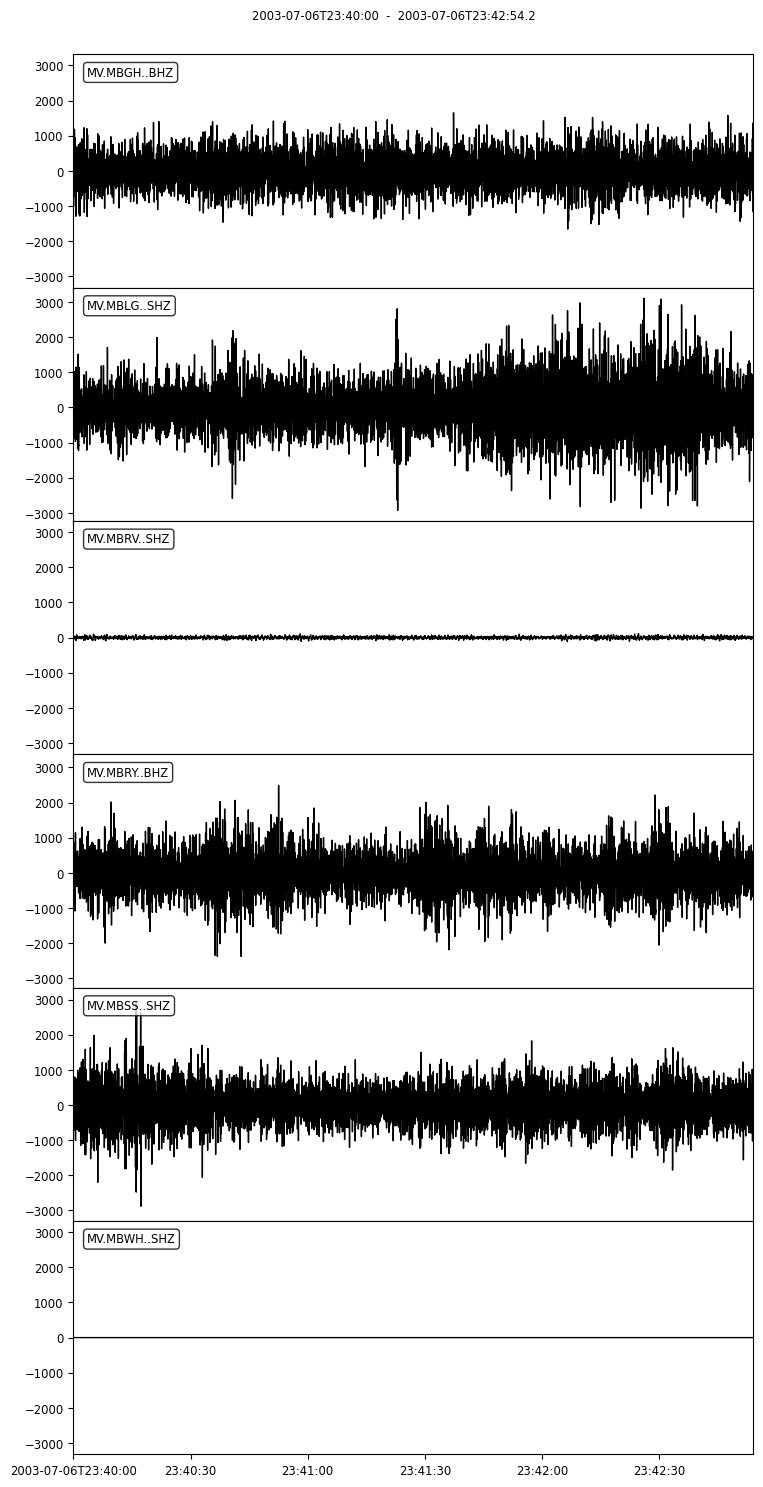

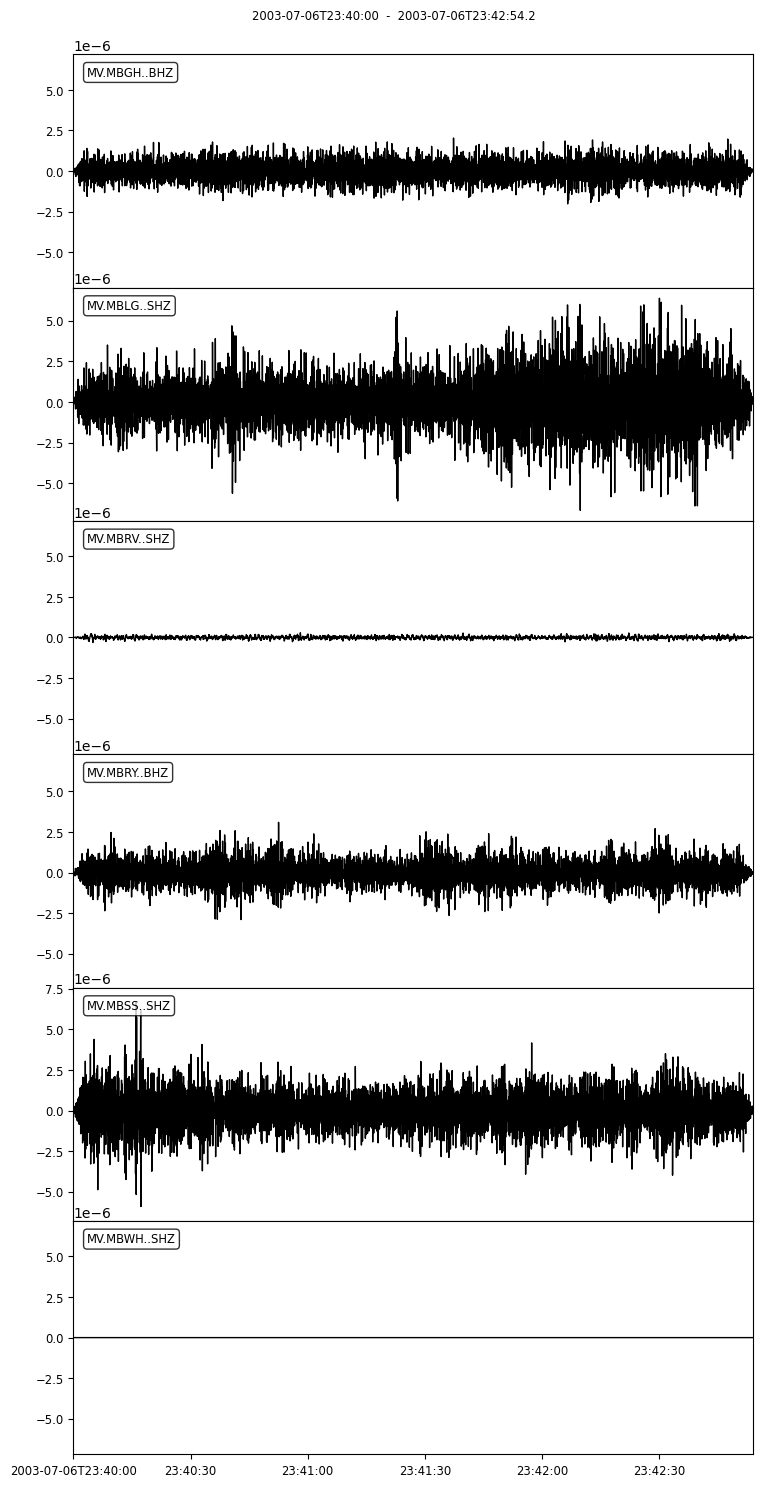

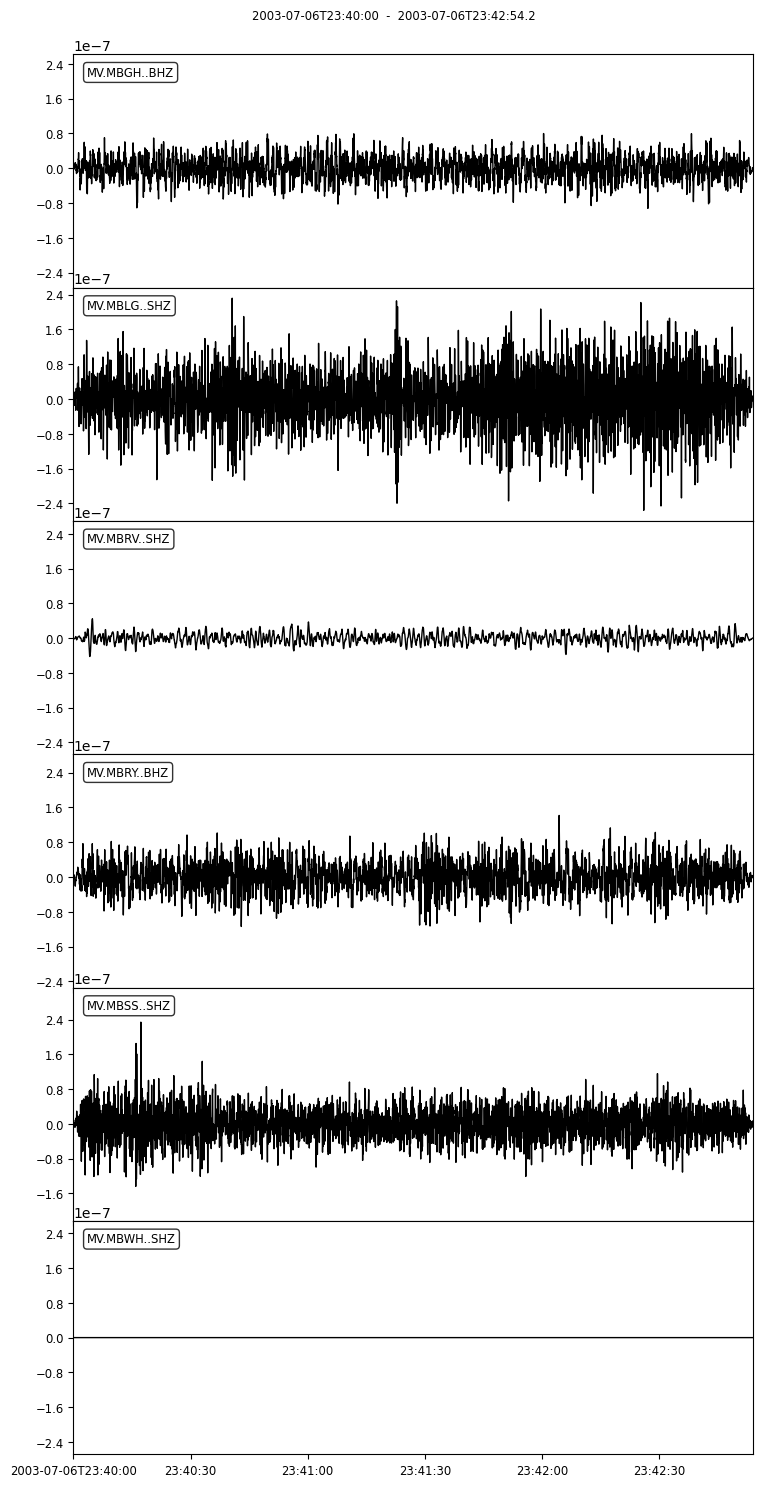

METRIC:  fratio


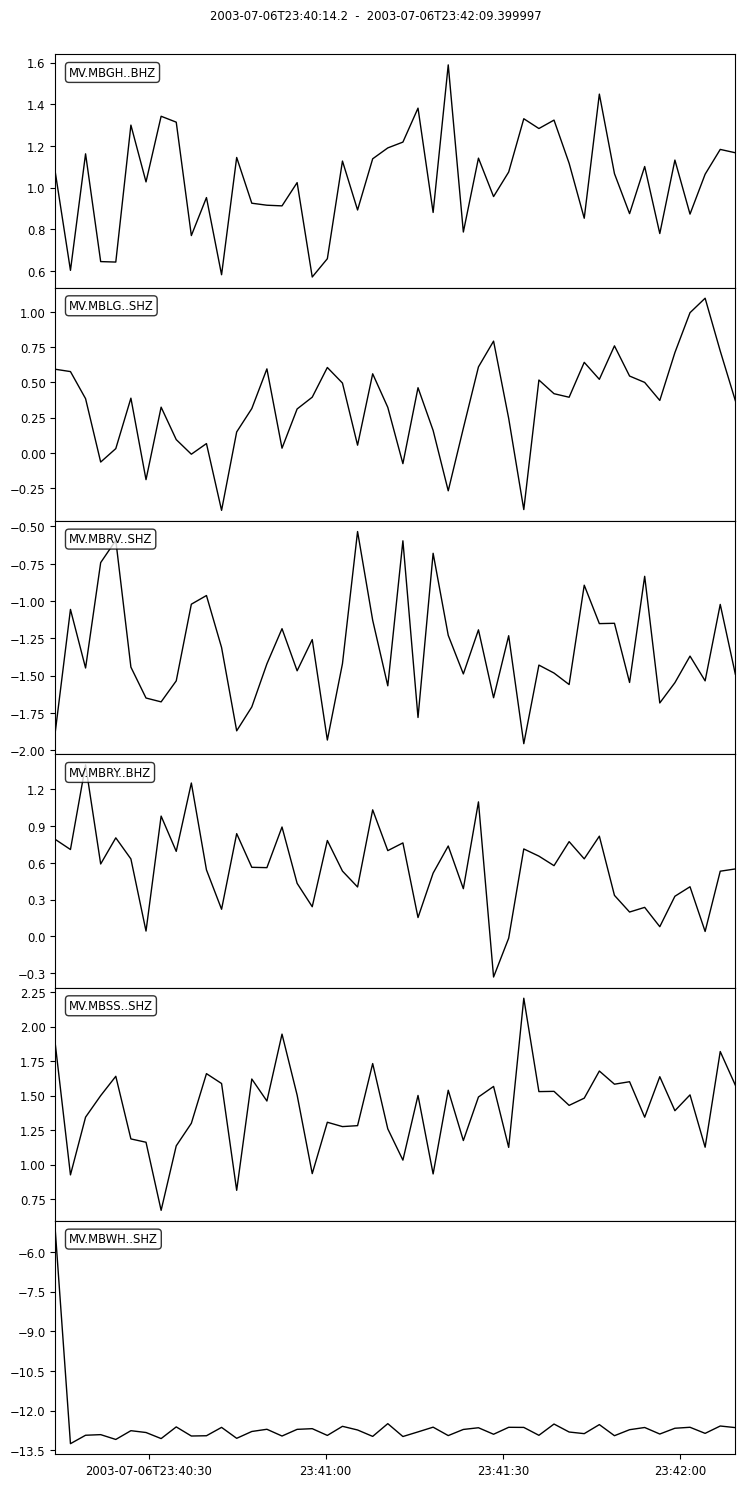

Dominant frequency for whole event: 2.9 Hz


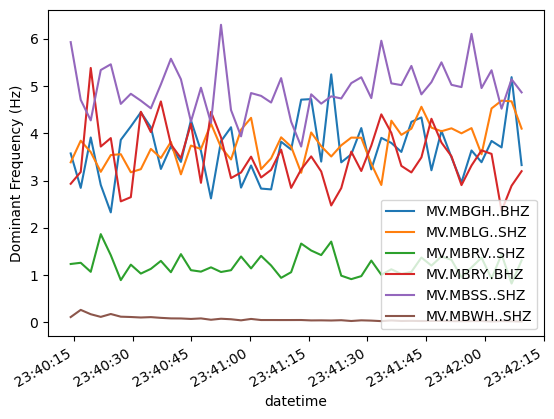

In [5]:
# examine 1 event
row = catDF.iloc[0]
evtime = obspy.UTCDateTime(row['datetime'])
print(evtime)
year = evtime.strftime('%Y')
month = evtime.strftime('%m')
duration = row['duration']
mseedfile = os.path.join(EVENTS_DIR, 'WAV', 'MV', year, month, row['filename'] + '.mseed')
st = obspy.read(mseedfile, 'MSEED')
dfdom, dfratio = compute_metrics(st, evtime, duration, show_response_plots=False, show_stream_plots=True, show_frequency_plots=True, return_dominantF=True)

print(f"Dominant frequency for whole event: {dfdom['mean'].mean():.1f} Hz")

In [14]:
dfratioPickle=os.path.join(CATALOG_DIR,'dfratio.pkl')
if os.path.isfile(dfratioPickle):
    dfratio_all = pd.read_pickle(dfratioPickle)
else:
    # process events
    subclasses = []
    dfratio_all = None
    max_i = 9999
    catDF['subclass'] = None
    for index, row in catDF.iterrows():
        #print(index, row)
        if index>max_i:
            continue
        evtime = obspy.UTCDateTime(row['datetime'])
        print(evtime)
        duration = row['duration']
        year = evtime.strftime('%Y')
        month = evtime.strftime('%m')
        mseedfile = os.path.join(EVENTS_DIR, 'WAV', 'MV', year, month, row['filename'] + '.mseed')    
        st = obspy.read(mseedfile, format='MSEED')
        dfdom, dfratio = compute_metrics(st, evtime, duration, show_response_plots=False, show_stream_plots=False, interactive=False)
        if len(dfratio)==0:
            dfratio_all = dfratio
        else:
            dfratio_all = pd.concat([dfratio_all, dfratio])
        #subclass = classify_event(dfdom, dfratio)
        #subclasses.append(subclass)
        #catDF.at[index, 'subclass']=subclass
    dfratio_all.to_pickle(dfratioPickle)

2003-07-06T23:40:14.200000Z
2003-07-07T00:00:14.200000Z
2003-07-07T00:02:56.920000Z
2003-07-07T00:34:46.093333Z
2003-07-07T00:51:51.813333Z
2003-07-07T01:00:14.200000Z
2003-07-07T01:02:33.226667Z
2003-07-07T02:02:38.946667Z
2003-07-07T02:42:21.053333Z
2003-07-07T03:00:11.840000Z
2003-07-07T03:03:17.226666Z
2003-07-07T03:16:07.640000Z
2003-07-07T03:41:23.280000Z
2003-07-07T04:53:59.773334Z
2003-07-07T05:00:14.200000Z
2003-07-07T05:08:06.400000Z
2003-07-07T05:12:17.586666Z
2003-07-07T05:13:01.933333Z
2003-07-07T05:48:40.880000Z
2003-07-07T05:58:16.626666Z
2003-07-07T06:23:48.960000Z
2003-07-07T07:07:25.680000Z
2003-07-07T07:28:15.986667Z
2003-07-07T07:39:19.466667Z
2003-07-07T08:23:07.880000Z
2003-07-07T09:00:14.200000Z
2003-07-07T09:28:48.946666Z
2003-07-07T09:48:38.000000Z
2003-07-07T10:02:13.560000Z
2003-07-07T10:11:27.853334Z
2003-07-07T10:13:42.026667Z
2003-07-07T10:50:07.080000Z
2003-07-07T11:00:14.200000Z
2003-07-07T11:03:18.080000Z
2003-07-07T11:12:28.600000Z
2003-07-07T11:14:31.

In [11]:
import pandas as pd
dfratio_all = pd.read_pickle(dfratioPickle)
print(dfratio_all)

                  datetime  MV.MBGH..BHZ  MV.MBLG..SHZ  MV.MBRV..SHZ  \
0  2003-07-06 23:40:14.200      1.071771      0.592976     -1.872802   
1  2003-07-06 23:40:16.760      0.603242      0.576520     -1.055945   
2  2003-07-06 23:40:19.320      1.162346      0.384552     -1.448580   
3  2003-07-06 23:40:21.880      0.645256     -0.064753     -0.742128   
4  2003-07-06 23:40:24.440      0.643031      0.030566     -0.593037   
..                     ...           ...           ...           ...   
0  2003-07-10 21:56:38.880      0.093564      0.490161     -1.240357   
1  2003-07-10 21:56:41.440     -0.532570      0.361457     -0.043387   
2  2003-07-10 21:56:44.000     -0.557390      0.340888     -1.484000   
3  2003-07-10 21:56:46.560     -0.047985     -0.059616     -2.065724   
4  2003-07-10 21:56:49.120     -0.096412      0.185791     -1.755104   

    MV.MBRY..BHZ  MV.MBSS..SHZ  MV.MBWH..SHZ      mean  
0       0.791360      1.869736     -5.220472 -0.461238  
1       0.709126     

<Axes: xlabel='datetime', ylabel='mean'>

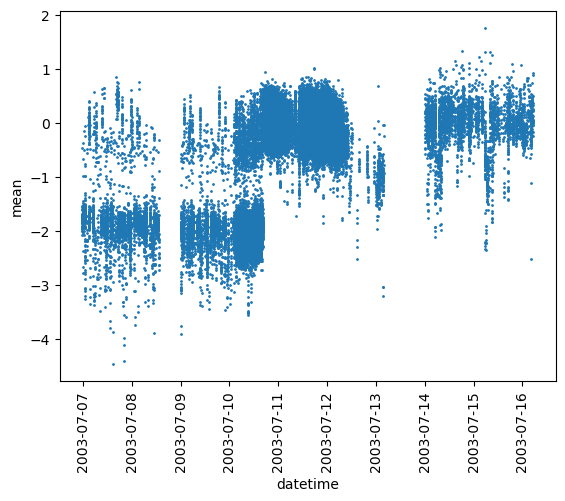

In [15]:
dfratio_all.plot.scatter(x='datetime', y='mean', s=1, rot=90)

MV.MBGH..BHZ
0.01
MV.MBLG..SHZ
0.32
MV.MBRV..SHZ
-1.19
MV.MBRY..BHZ
0.06
MV.MBSS..SHZ
1.20
MV.MBWH..SHZ
-4.28
mean
-0.63


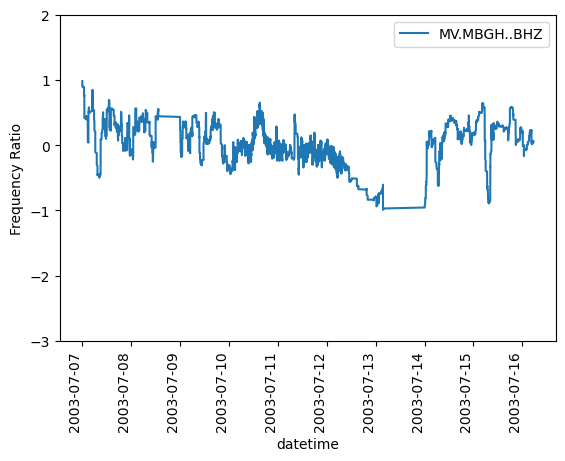

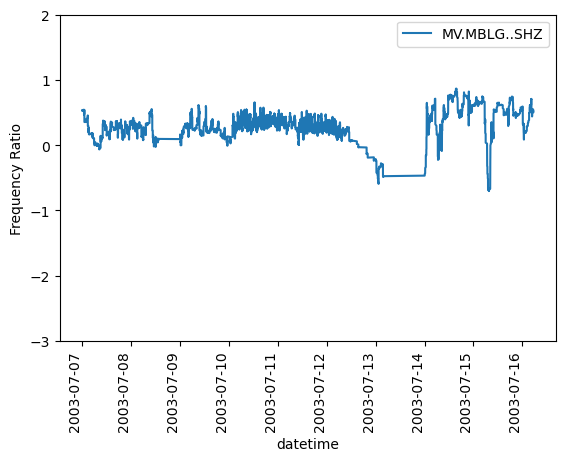

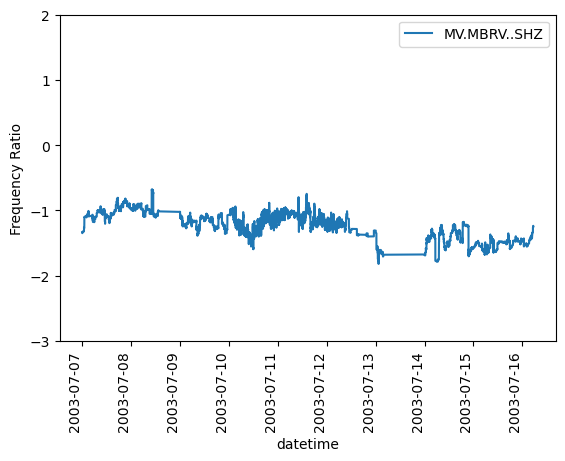

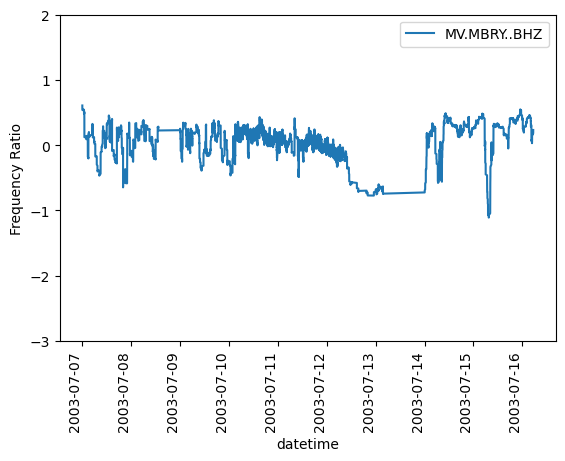

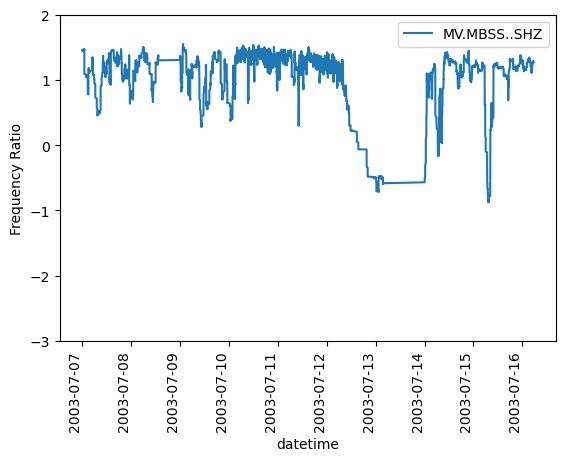

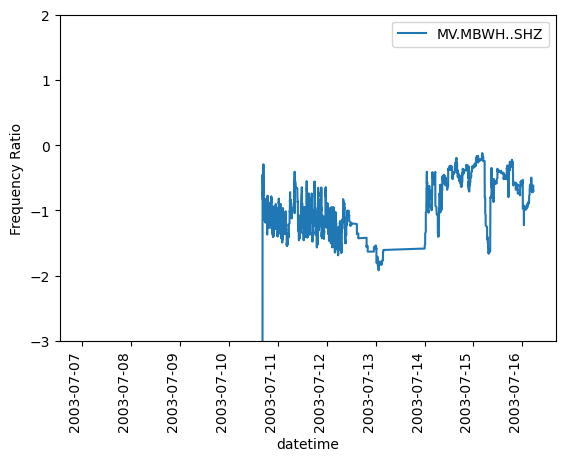

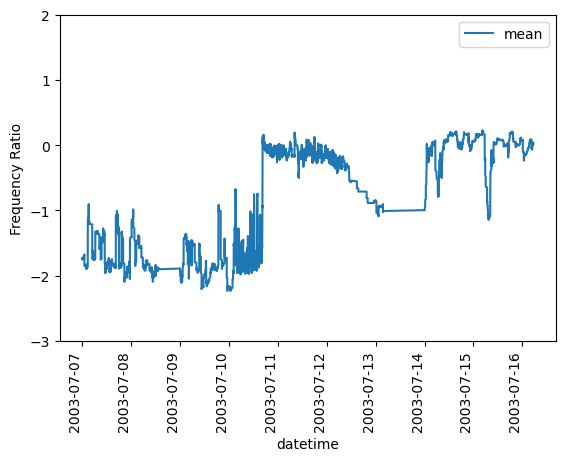

In [19]:
dfratio_mean10 = dfratio_all.copy()

for col in dfratio_all.columns:
    if col[0:2]=='MV' or col=='mean':
        dfratio_mean10[col] = dfratio_mean10[col].rolling(100).mean()
        print(col)
        #dfratio_all['mean10'] = dfratio_all.rolling(10).mean()
        #ax = dfratio_mean10.plot.scatter(x='datetime', y=col, s=1, rot=90)
        ax = dfratio_mean10.plot.line(x='datetime', y=col, rot=90, ylabel='Frequency Ratio')
        ax.set_ylim([-3.0, 2.0])
        print(f'{dfratio_all[col].mean():.2f}')
        plt.savefig('dfratio_MV_12July2003.png')

In [18]:
print(dfdom)

None


In [ ]:
occurrence = {item: subclasses.count(item) for item in subclasses}
#print(occurrence.get('e'))
print(occurrence)

In [ ]:
'''
# Define a source location for Redoubt volcano. Station distances to this lat/lon are used to "reduce" the displacement to 1 km distance.
source = {'lat':60.4845, 'lon':-152.7392}
print(source)

# Generate a Reduced Displacement object, assuming body waves (surfaceWaves=False) and no inelastic attenuation (Q=None)
DRobj = dsamObj.compute_reduced_displacement(inv, source, surfaceWaves=False, Q=None)
DRobj.plot()

# Generate a Reduced Displacement object, assuming surface waves (surfaceWaves=True) and no inelastic attenuation (Q=None)
DRSobj = dsamObj.compute_reduced_displacement(inv, source, surfaceWaves=True, Q=None)
DRSobj.plot()
'''